In [15]:
from IPython.display import clear_output
!pip install requests
!pip install --upgrade pandas
!pip install konlpy
!pip install gensim
!cp -R /home/work/deep/jdk1.8.0_201 /usr/lib/jvm
clear_output()

In [16]:
import pandas as pd
import numpy as np
import requests
df = pd.read_csv('data/NewsMainOutput.csv', encoding='UTF-8',sep='|')

## News Data Load(국제유가 관련 뉴스)

In [17]:
df['main']= df.main.str.replace("\t","")
df['main']= df['main'].str.replace('[','')
df['main']= df['main'].str.replace(']','')
df['main']= df['main'].str.replace('동아일보','')
df['main']= df['main'].str.replace('동아닷컴','')
df.dropna(how='any',inplace=True) 
#df['main']= df['main'].astype('str')
data = {'time': df.time.unique(),'main' : df.groupby(['time'])['main'].apply(lambda x: "%s" % ', '.join(x)).values}
df = pd.DataFrame(data=data)

In [18]:
from konlpy.tag import Twitter
tagger = Twitter()

def kor_noun(text):
    words = []
    for w in tagger.nouns(text):
        if len(w) > 1:
            words.append(w)
    return words

/usr/local/lib/python3.5/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
topic_lists = []
for i in range(len(df)):
    cv = CountVectorizer(tokenizer=kor_noun, max_features=1000)
    articles = df['main'][i:i+1]
    tdm = cv.fit_transform(articles)
    words = cv.get_feature_names()
    corpus = Sparse2Corpus(tdm.T)
    lda = LdaModel(corpus=corpus, id2word=dict(enumerate(words)),
               num_topics=1, passes=10, iterations=50,
               random_state=1234)
    word_lists = []
    for cnt in range(10):
        word_lists.append(lda.show_topic(0)[cnt][0])
    topic_lists.append(word_lists)

In [22]:
df = pd.concat([df,pd.DataFrame(np.array(topic_lists),columns=['top1','top2','top3','top4','top5','top6','top7','top8','top9','top10'])],axis=1)
df = pd.concat([df[['time']],pd.concat([pd.get_dummies(df.top1),pd.get_dummies(df.top2),pd.get_dummies(df.top3)
          ,pd.get_dummies(df.top4),pd.get_dummies(df.top5),pd.get_dummies(df.top6)
          ,pd.get_dummies(df.top7),pd.get_dummies(df.top8),pd.get_dummies(df.top9)
          ,pd.get_dummies(df.top10)], axis=1, sort=False).fillna(0)],axis=1)
df = df.sum(axis=1, level=0)
df['time'] = pd.to_datetime(data['time'], format='%Y.%m.%d.')

## Load 주유소 기름 Data

In [38]:
df_oil = pd.read_csv('주유소_평균판매가격_제품별.csv',encoding='UTF-8')
df_oil['time'] = pd.to_datetime(df_oil['구분'], format='%Y년%m월%d일')
df = df_oil[['time','고급휘발유','보통휘발유','자동차용경유']].merge(df,on='time',how='outer').fillna(0)

## 다우존스 / 코스피 Data

In [41]:
df_dji = pd.read_csv('다우존스 내역.csv', encoding='UTF-8')
kospi = pd.read_csv('코스피지수 내역.csv', encoding='UTF-8')
df_dji['날짜'] = pd.to_datetime(df_dji['날짜'], format='%Y년 %m월 %d일')
kospi['날짜'] = pd.to_datetime(kospi['날짜'], format='%Y년 %m월 %d일')
df_dji['현재가'] = df_dji['현재가'].str.replace(',','').astype('float')
kospi['현재가'] = kospi['현재가'].str.replace(',','').astype('float')
df_stock = df_dji[['날짜','현재가']].merge(kospi[['날짜','현재가']],on='날짜',how='outer')
df_stock['현재가_x'] = df_stock['현재가_x'].fillna(df_stock.현재가_x.astype('float32').mean())
df_stock['현재가_y'] = df_stock['현재가_y'].fillna(df_stock.현재가_y.astype('float32').mean())
df_stock['time'] = df_stock['날짜'].dt.strftime('%Y-%m-%d')
df['time'] = df['time'].dt.strftime('%Y-%m-%d')
df = df.merge(df_stock[['time','현재가_x','현재가_y']],how='outer',on="time")
df['현재가_x'] = df['현재가_x'].fillna(df.현재가_x.astype('float32').mean())
df['현재가_y'] = df['현재가_y'].fillna(df.현재가_y.astype('float32').mean())

## 환율 Data(USD)

In [ ]:
usd_list = []
for date in list(df.time.unique()):
    url = 'https://www.koreaexim.go.kr/site/program/financial/exchangeJSON?authkey=E24WPCtlRO2NyplVreVjosPe4XmFFtmb&searchdate={}&data=AP01'.format(date)
    print('{} search start'.format(date))
    try:
        response = requests.get(url)
    except:
        print('retry')
        response = requests.get(url)
    if len(response.json()) == 0:
        usd_list.append(None)
        print('Null')
    else:
        for i in response.json():
            if i['cur_unit'] == 'USD':
                usd_list.append(i['ttb'])
                print(i['ttb'])
    print('{} search end'.format(date))

In [52]:
pd.DataFrame(data={'er':usd_list,'time':df.time.unique()}).to_csv('er.csv',encoding='UTF-8')

In [56]:
df_er = pd.read_csv('er.csv',encoding='UTF-8',index_col=0)
df_er['er'] = df_er['er'].str.replace(',','').astype('float')
df_er['er'] = df_er['er'].fillna(df_er['er'].mean())
df_er['time'] = pd.to_datetime(df_er['time'], format='%Y-%m-%d').astype('str')
df = df.merge(df_er,on='time',how='outer')

##  Crude Oil Prices: West Texas Intermediate (WTI) Data (y 값)

In [62]:
df_oil = pd.read_csv('DCOILWTICO.csv', encoding='UTF-8')
df_oil.columns = ['time','price']
df_oil = df_oil.drop(df.index[list(df_oil[df_oil.price=='.'].index)])
df_oil['price']= df_oil.price.astype('float')
df=df.merge(df_oil,how='outer',on="time")

In [78]:
df_copy = df.copy()

In [ ]:
df = df.dropna(how='any').set_index('time')

In [86]:
from keras.models import Sequential, load_model
from keras import layers
from keras import backend as K
from keras import optimizers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing import image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from datetime import datetime

In [88]:
from sklearn.preprocessing import MinMaxScaler
scalerX = MinMaxScaler()
x = scalerX.fit_transform(df)
scalery = MinMaxScaler()
y = scalery.fit_transform(df.iloc[:,[-1]])

Text(0, 0.5, 'Close')

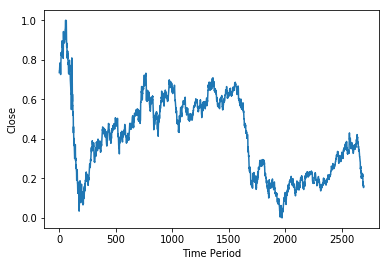

In [89]:
plt.plot(y)
plt.xlabel("Time Period")
plt.ylabel("Close")

In [90]:
# Your answer comes here.
SEQ_LEN = 3

# build a dataset
dataX = []
dataY = []

for i in range(0, len(y) - SEQ_LEN):
    _x = x[i:i + SEQ_LEN]
    _y = y[i + SEQ_LEN]
    dataX.append(_x)
    dataY.append(_y)

dataX = np.array(dataX)
dataY = np.array(dataY)

In [91]:
dataY.shape

(2694, 1)

In [92]:
train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size
Xtrain, Xtest = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
ytrain, ytest = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

In [93]:
np.shape(Xtrain), np.shape(Xtest)

((2155, 3, 954), (539, 3, 954))

In [94]:
# Your answer comes here.
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
K.clear_session()
model = Sequential()
model.add(LSTM(32, input_shape=(3, 954), return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 32)             126336    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 129,489
Trainable params: 129,489
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Your answer comes here.
from keras.callbacks import TensorBoard
import time
now = time.strftime("%c")
callbacks_list = [
    ModelCheckpoint(filepath='stock'+now+'.h5',monitor='val_loss',save_best_only=True)
]
history=model.fit(Xtrain, ytrain, validation_data=(Xtest,ytest),epochs=50, verbose=1,callbacks=callbacks_list)

Train on 2155 samples, validate on 539 samples
Epoch 1/50
2155/2155 [==============================] - 1s 387us/step - loss: 2.2460e-04 - mean_absolute_error: 0.0106 - val_loss: 0.0023 - val_mean_absolute_error: 0.0307
Epoch 2/50
2155/2155 [==============================] - 1s 388us/step - loss: 2.4379e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0028 - val_mean_absolute_error: 0.0345
Epoch 3/50
2155/2155 [==============================] - 1s 379us/step - loss: 2.3046e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0024 - val_mean_absolute_error: 0.0298
Epoch 4/50
2155/2155 [==============================] - 1s 377us/step - loss: 2.3507e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0025 - val_mean_absolute_error: 0.0316
Epoch 5/50
2155/2155 [==============================] - 1s 375us/step - loss: 2.1864e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0027 - val_mean_absolute_error: 0.0358
Epoch 6/50
2155/2155 [==============================] - 1s 378us/step - loss: 2.4741e-04 - me

In [97]:
model = load_model('stockThu May 30 06:00:37 2019.h5')  # best model 불러오기
test_predict = model.predict(Xtest)
test_predict_back = scalery.inverse_transform(test_predict)
ytest_back = scalery.inverse_transform(ytest)

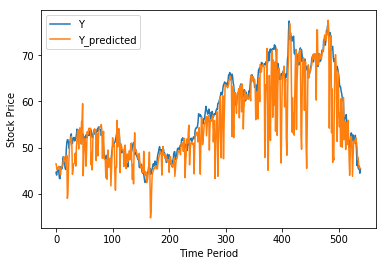

In [98]:
# Plot predictions
plt.plot(ytest_back, label = 'Y')
plt.plot(test_predict_back, label = 'Y_predicted')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()